### **BRAIN TUMOR DETECTION**

<p align="center">
  <img src="./logo/dataset-cover.jpg" alt="Brain MRI Example" width="600"/>
</p>


This dataset contains MRI brain scans categorized into four classes: **glioma**, **meningioma**, **no tumor (healthy)**, and **pituitary**.  
The images are organized into separate folders based on these labels.  
It is commonly used for brain tumor classification and segmentation tasks to support the development and evaluation of medical image analysis models.

- **Glioma** – A type of tumor that originates in the brain or spinal cord glial cells, often malignant and fast-growing.  
- **Meningioma** – A tumor that forms on the meninges, the protective layers around the brain and spinal cord, usually benign.  
- **No tumor (healthy)** – Normal brain tissue with no signs of abnormal growth or lesions.  
- **Pituitary** – Tumors located in the pituitary gland, which can affect hormone production and cause various systemic symptoms.

### **Current Data Sources**

- [Figshare: Brain Tumor Dataset](https://figshare.com/articles/dataset/brain_tumor_dataset/1512427)  
- [Kaggle: Brain Tumor Classification MRI](https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri)  
- [Kaggle: Brain Tumor Detection](https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection?select=no)

In [23]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report,f1_score
import numpy as np

In [2]:
device = torch.device("cuda")
device

device(type='cuda')

In [3]:
data_dir = "dataset/brain-tumor-mri-dataset"

### **Count the number of images per class**

In [4]:
class_counts = {}
for cls in os.listdir(data_dir):
    class_path = os.path.join(data_dir, cls)
    if os.path.isdir(class_path):
        class_counts[cls] = len(os.listdir(class_path))

# Display counts
print("Image Count per Class:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

Image Count per Class:
glioma: 1621
meningioma: 1775
notumor: 2000
pituitary: 1757


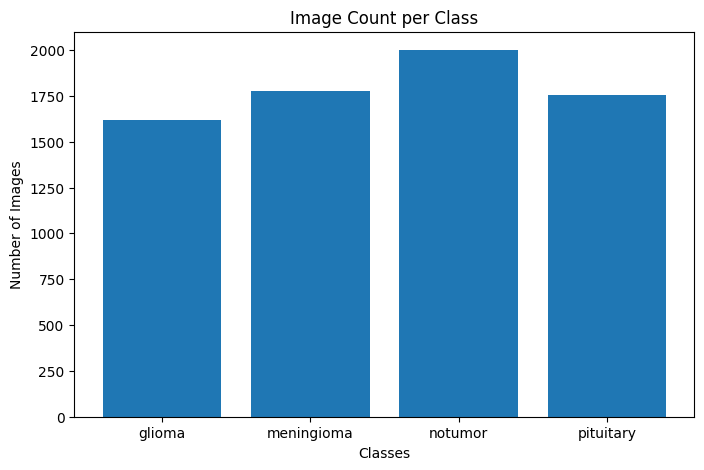

In [5]:
# Bar graph
plt.figure(figsize=(8,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Image Count per Class")
plt.show()

### **Data Preprocessing + Augmentation**

In [6]:

# Advanced Preprocessing + Augmentation
train_transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

train_data = datasets.ImageFolder(data_dir, transform=train_transform)
test_data = datasets.ImageFolder(data_dir, transform=test_transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

class_names = train_data.classes
class_names


['glioma', 'meningioma', 'notumor', 'pituitary']

### **Define CNN Model**

In [7]:
class BrainTumorCNN(nn.Module):
    def __init__(self):
        super(BrainTumorCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 18 * 18, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    

model = BrainTumorCNN().to(device)



In [8]:
from torchsummary import summary

summary(model, input_size=(3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 150, 150]             896
       BatchNorm2d-2         [-1, 32, 150, 150]              64
              ReLU-3         [-1, 32, 150, 150]               0
         MaxPool2d-4           [-1, 32, 75, 75]               0
            Conv2d-5           [-1, 64, 75, 75]          18,496
       BatchNorm2d-6           [-1, 64, 75, 75]             128
              ReLU-7           [-1, 64, 75, 75]               0
         MaxPool2d-8           [-1, 64, 37, 37]               0
            Conv2d-9          [-1, 128, 37, 37]          73,856
      BatchNorm2d-10          [-1, 128, 37, 37]             256
             ReLU-11          [-1, 128, 37, 37]               0
        MaxPool2d-12          [-1, 128, 18, 18]               0
           Linear-13                  [-1, 256]      10,617,088
             ReLU-14                  [

### **Training Setup**

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 200

train_loss_list = []
train_acc_list = []
val_acc_list = []


### **Training**

In [10]:
for epoch in range(epochs):
    model.train()
    running_loss = 0
    total = 0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss_list.append(running_loss/len(train_loader))
    train_acc_list.append(100 * correct/total)

    if (epoch+1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")


Epoch [20/200], Loss: 0.3232, Accuracy: 87.56%
Epoch [40/200], Loss: 0.2272, Accuracy: 91.19%
Epoch [60/200], Loss: 0.1777, Accuracy: 93.22%
Epoch [80/200], Loss: 0.1410, Accuracy: 94.44%
Epoch [100/200], Loss: 0.1147, Accuracy: 95.60%
Epoch [120/200], Loss: 0.1015, Accuracy: 96.18%
Epoch [140/200], Loss: 0.0823, Accuracy: 96.66%
Epoch [160/200], Loss: 0.0737, Accuracy: 97.23%
Epoch [180/200], Loss: 0.0635, Accuracy: 97.76%
Epoch [200/200], Loss: 0.0593, Accuracy: 97.82%


### **Model Evaluation (Precision, Recall, Report)**

In [11]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Accuracy : 0.9972039703620859
Precision: 0.9972146331160687
Recall   : 0.997020665590882

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.99      1.00      1621
  meningioma       0.99      1.00      0.99      1775
     notumor       1.00      1.00      1.00      2000
   pituitary       1.00      1.00      1.00      1757

    accuracy                           1.00      7153
   macro avg       1.00      1.00      1.00      7153
weighted avg       1.00      1.00      1.00      7153



In [24]:
f1_score = f1_score(y_true, y_pred, average='macro')

print(f"F1_score:{f1_score}")


F1_score:0.9971097571335299


### **Plot Loss & Accuracy**

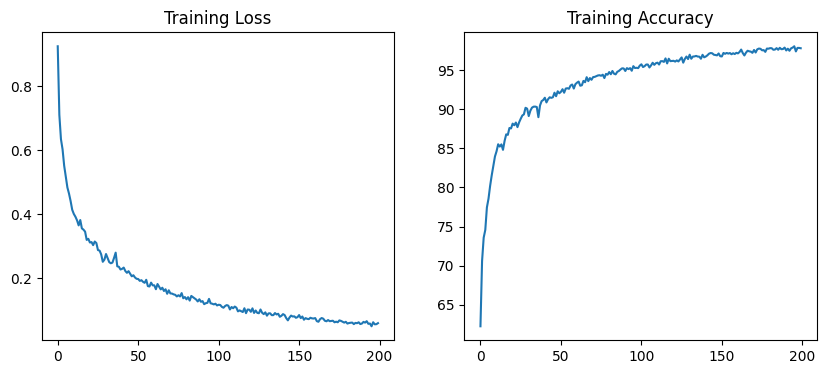

In [12]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_loss_list)
plt.title("Training Loss")

plt.subplot(1,2,2)
plt.plot(train_acc_list)
plt.title("Training Accuracy")
plt.show()


In [13]:
torch.save(model.state_dict(), "brain_tumor_cnn_model.pth")
print("Saved as brain_tumor_cnn_model.pth")

Saved as brain_tumor_cnn_model.pth


## Testing

In [16]:
model.load_state_dict(torch.load("brain_tumor_cnn_model.pth", map_location=device))
model.eval()

print("Model loaded successfully.")


Model loaded successfully.


In [17]:
# Classes MUST match your folder order
class_names = ["glioma", "meningioma", "notumor", "pituitary"]

# Same preprocessing used during training
transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        _, pred = torch.max(outputs, 1)
        prediction = class_names[pred.item()]

    print("Predicted class:", prediction)
    return prediction


In [21]:

image_path=rf"E:\Brain tumor Detection\dataset\brain-tumor-mri-dataset\pituitary\pi-0005.jpg"

In [22]:
from PIL import Image

predict_image(image_path)


Predicted class: pituitary


'pituitary'